<h1 style="text-align:center">Data Science and Machine Learning Capstone Project</h1>
<img style="float:right" src="https://prod-edxapp.edx-cdn.org/static/edx.org/images/logo.790c9a5340cb.png">
<p style="text-align:center">IBM: DS0720EN</p>
<p style="text-align:center">Question 3 of 4</p>

1. [Problem Statement](#problem)
2. [Question 3](#question)
3. [Data Cleaning and Standardization](#wrangling)
4. [Analyzing and Visualizing](#analysis)
5. [Concluding Remarks](#conclusion)

<a id="problem"></a>
# Problem Statement
---

The people of New York use the 311 system to report complaints about the non-emergency problems to local authorities. Various agencies in New York are assigned these problems. The Department of Housing Preservation and Development of New York City is the agency that processes 311 complaints that are related to housing and buildings.

In the last few years, the number of 311 complaints coming to the Department of Housing Preservation and Development has increased significantly. Although these complaints are not necessarily urgent, the large volume of complaints and the sudden increase is impacting the overall efficiency of operations of the agency.

Therefore, the Department of Housing Preservation and Development has approached your organization to help them manage the large volume of 311 complaints they are receiving every year.

The agency needs answers to several questions. The answers to those questions must be supported by data and analytics. These are their  questions:

<a id="question"></a>
# Question 3
---

Does the Complaint Type that you identified in response to Question 1 have an obvious relationship with any particular characteristic or characteristic of the Houses?

## Approach
Determine how to link the 311 data with the PLUTO data then identify whether or not there are any correlations between the HEAT/HOT WATER complaints from Question 1 to the PLUTO house information.

## Load Data
Separately from this notebook:

The [New York 311](https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9) data was loaded by [SODA](https://data.cityofnewyork.us/resource/fhrw-4uyv.csv?$limit=100000000&Agency=HPD&$select=created_date,unique_key,complaint_type,incident_zip,incident_address,street_name,address_type,city,resolution_description,borough,latitude,longitude,closed_date,location_type,status) into a Pandas DataFrame then saved to a pickle file.

The [New York PLUTO](https://data.cityofnewyork.us/City-Government/Primary-Land-Use-Tax-Lot-Output-PLUTO-/xuk2-nczf) data was downloaded.  The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, only the BX_18v1.csv file was loaded into a Pandas DataFrame then saved to a pickle file.

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import gc

files_path = 'C:\\Users\\It_Co\\Documents\\DataScience\\Capstone\\' #local
#files_path = './' #IBM Cloud / Watson Studio

In [2]:
b311 = pd.read_pickle(files_path + 'ny311full.pkl')

#bPlu = pd.read_csv(files_path + 'BX_18v1.csv', usecols=['Address','BldgArea','BldgDepth','BuiltFAR','CommFAR','FacilFAR','Lot','LotArea','LotDepth','NumBldgs','NumFloors','OfficeArea','ResArea','ResidFAR','RetailArea','YearBuilt','YearAlter1','ZipCode', 'YCoord', 'XCoord'])
#bPlu.to_pickle(files_path + 'BX_18v1.pkl')
bPlu = pd.read_pickle(files_path + 'BX_18v1.pkl')

print("NY 311 shape %s" % (b311.shape,))
print("BRONX PLUTO shape %s" % (bPlu.shape,))

NY 311 shape (5862383, 15)
BRONX PLUTO shape (89854, 20)


<a id="wrangling"></a>
# Data Cleaning and Standardization
---

Observations with missing or malformed data elements will need to be corrected or removed.  The 311 and the PLUTO data sets will need to be "joined" together by the common "address" element, which means the addresses will need to be standardized to a consistent layout to allow the addresses to be compared consistently.

## NY 311

### General

In [3]:
#Remove columns deemed unnecessary for this question.
b311.drop(['created_date','street_name','address_type','resolution_description','closed_date','location_type','status','unique_key','latitude','longitude'], axis=1, inplace=True)

#Normalize relevant strings to uppercase so different casing won't appear as separate values.
b311['incident_address'] = b311['incident_address'].str.upper()
b311['city'] = b311['city'].str.upper()
b311['borough'] = b311['borough'].str.upper()
#We only care if it is the combined "heating and hot water" from Question 1, or some other type of complaint.
b311.loc[b311[b311["complaint_type"].isin(["HEAT/HOT WATER","HEATING"])==True].index,'complaint_type'] = "HEAT"
b311.loc[b311[b311["complaint_type"].isin(["HEAT"])==False].index,'complaint_type'] = "OTHER"

In [4]:
#Print some initial information for comparison during later steps.
print("shape %s" % str(b311.shape))
print("--nulls below--")
print(b311.isnull().sum())
print("--types below--")
print(b311.dtypes)
b311.head()

shape (5862383, 5)
--nulls below--
complaint_type          0
incident_zip        80611
incident_address    52831
city                80210
borough                 0
dtype: int64
--types below--
complaint_type       object
incident_zip        float64
incident_address     object
city                 object
borough              object
dtype: object


,complaint_type,incident_zip,incident_address,city,borough
0,OTHER,11435.0,141-40 PERSHING CRESCENT,JAMAICA,QUEENS
1,OTHER,11223.0,1702 WEST 1 STREET,BROOKLYN,BROOKLYN
2,HEAT,11233.0,1711 FULTON STREET,BROOKLYN,BROOKLYN
3,OTHER,10456.0,881 CAULDWELL AVENUE,BRONX,BRONX
4,OTHER,11205.0,196 CLINTON AVENUE,BROOKLYN,BROOKLYN


### Standardize Borough
Leveraging findings found while standardizing during Question 2.

In [5]:
b311['borough'].value_counts()

BROOKLYN         1692795
BRONX            1566246
MANHATTAN        1020161
UNSPECIFIED       873226
QUEENS            624323
STATEN ISLAND      85632
Name: borough, dtype: int64

In [6]:
#Correct rows where borough was entered in the city column with "UNSPECIFIED" in the borough column.
five_boroughs = ["BROOKLYN","BRONX","MANHATTAN","QUEENS","STATEN ISLAND"]
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(five_boroughs)].index
b311.loc[which_rows_to_adjust,'borough']=b311.loc[which_rows_to_adjust,'city']
b311.loc[which_rows_to_adjust,'city']=np.nan
#Drop a few rows of ambiguous data.
b311.drop(b311[(b311["borough"]=='MANHATTAN')&(b311["city"]=='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
#Fill in UNSPECIFIED borough when city was entered as NEW YORK.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'borough']="MANHATTAN"
b311.loc[which_rows_to_adjust,'city']=np.nan
#Although the city for most of the "NEW YORK" ones are the only ones that technically got the "city" column valued correctly,
#since every other row uses city as "neighborhood":  Standardize these.
which_rows_to_adjust = b311[(b311["city"]=='NEW YORK')].index
b311.loc[which_rows_to_adjust,'city']=np.nan
#Any still unspecified boroughs with a value in "city" are in the Queens borough.  The "city" is actually a "neighborhood".
queens_neighborhoods = b311[(b311['borough']=='UNSPECIFIED')&(b311['city'].isnull()==False)]['city'].unique()
#Standardize borough for Queens neighborhoods.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isin(queens_neighborhoods)].index
b311.loc[which_rows_to_adjust,'borough']="QUEENS"
#Null the borough if it still shows up as unspecified borough as there is no other information from which to derive it.
which_rows_to_adjust = b311[(b311["borough"]=='UNSPECIFIED')&b311["city"].isnull()].index
b311.loc[which_rows_to_adjust,'borough']=np.nan

In [7]:
b311['borough'].value_counts()

BROOKLYN         1988158
BRONX            1816914
MANHATTAN        1175218
QUEENS            728676
STATEN ISLAND      99998
Name: borough, dtype: int64

### Filter NY 311 data by borough to only include BRONX
The instructions at ( Course / 1. Project Challenge Details and Setup / Datasets Used in this Course / Datasets ) said "Use only the part that is specific to the borough that you are interested in based on your analysis."  My answer for Question 2 suggested the borough with the biggest HEAT/HOT WATER problem was BRONX.  For that reason, I am only considering the BRONX data.

In [8]:
b311.drop(b311[(b311["borough"]!='BRONX')].index, axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
b311['borough'].value_counts()

BRONX    1816914
Name: borough, dtype: int64

### Remove unnecessary columns

In [9]:
#Remove columns no longer necessary
b311.drop(['borough','city'], axis=1, inplace=True)
print(b311.shape)
print(b311.isnull().sum())
b311.head()

(1816914, 3)
complaint_type         0
incident_zip        8083
incident_address       1
dtype: int64


,complaint_type,incident_zip,incident_address
0,OTHER,10456.0,881 CAULDWELL AVENUE
1,HEAT,10457.0,4487 3 AVENUE
2,OTHER,10452.0,133 CLARKE PLACE EAST
3,OTHER,10453.0,2076 CRESTON AVENUE
4,OTHER,10471.0,6035 BROADWAY


In [10]:
# Drop the one observation with the missing address as there will be no way to tie it to any PLUTO data.
b311.dropna(subset=['incident_address'], axis=0, inplace=True)
b311.reset_index(drop=True, inplace=True)
print(b311.isnull().sum())
b311['incident_address'].value_counts().head()

complaint_type         0
incident_zip        8082
incident_address       0
dtype: int64


1025 BOYNTON AVENUE        9854
3810 BAILEY AVENUE         7171
750 GRAND CONCOURSE        4412
888 GRAND CONCOURSE        4271
3555 BRUCKNER BOULEVARD    4076
Name: incident_address, dtype: int64

## BRONX PLUTO

In [11]:
print("shape %s" % str(bPlu.shape))
print("---isnull follows---")
print(bPlu.isnull().sum())
bPlu.head()

shape (89854, 20)
---isnull follows---
Lot              0
ZipCode        329
Address         69
LotArea          0
BldgArea         0
ResArea          0
OfficeArea       0
RetailArea       0
NumBldgs         0
NumFloors        0
LotDepth         0
BldgDepth        0
YearBuilt        0
YearAlter1       0
BuiltFAR         0
ResidFAR         0
CommFAR          0
FacilFAR         0
XCoord        3259
YCoord        3259
dtype: int64


,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,1,10454.0,122 BRUCKNER BOULEVARD,15000,0,0,0,0,1,0.0,200.0,0.0,0,0,0.00,6.02,5.0,6.5,1005957.0,232162.0
1,4,10454.0,126 BRUCKNER BOULEVARD,13770,752,0,272,0,2,1.0,100.0,16.0,1931,1994,0.05,6.02,5.0,6.5,1006076.0,232156.0
2,10,10454.0,138 BRUCKNER BOULEVARD,35000,39375,0,0,0,1,2.0,200.0,200.0,1931,0,1.13,6.02,5.0,6.5,1006187.0,232036.0
3,17,10454.0,144 BRUCKNER BOULEVARD,2500,12500,12500,0,0,1,5.0,100.0,85.0,1931,2001,5.00,6.02,5.0,6.5,1006299.0,232033.0
4,18,10454.0,148 BRUCKNER BOULEVARD,1875,8595,6876,0,1719,1,5.0,75.0,70.0,1920,2009,4.58,6.02,5.0,6.5,1006363.0,232040.0


### General

In [12]:
bPlu.dtypes

Lot             int64
ZipCode       float64
Address        object
LotArea         int64
BldgArea        int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumBldgs        int64
NumFloors     float64
LotDepth      float64
BldgDepth     float64
YearBuilt       int64
YearAlter1      int64
BuiltFAR      float64
ResidFAR      float64
CommFAR       float64
FacilFAR      float64
XCoord        float64
YCoord        float64
dtype: object

In [13]:
#Normalize relevant strings to uppercase so different casing won't appear as separate values.
bPlu['Address'] = bPlu['Address'].str.upper()

In [14]:
# Drop the observations with missing address as there will be no way to tie it to any 311 data.
bPlu.dropna(subset=['Address'], axis=0, inplace=True)
bPlu.reset_index(drop=True, inplace=True)

## Standardization of Addresses
Leveraging standardization methods developed during question 2.

In [15]:
print("BRONX 311 unique addresses: %s" % b311['incident_address'].unique().size)
print("BRONX PLUTO unique addresses: %s" % bPlu['Address'].unique().size)

BRONX 311 unique addresses: 29216
BRONX PLUTO unique addresses: 87017


<p style="color:Red;">Determine how much overlap.  Ideally all 29K BRONX 311 addresses will be represented in the PLUTO set.</p>

In [16]:
def WhichAddressesNotInPluto(howManyTopToShow):
    complaints = set(b311['incident_address'].unique())
    pluto = set(bPlu['Address'].unique())
    #Determine which 311 addresses were not found in PLUTO to gain insight as to why.
    differences = complaints.difference(pluto)
    print("Records not in PLUTO: %s.  Percent: %s" % (len(differences), "{:.2%}".format(len(differences) / len(complaints))))
    print("---Top %i---" % howManyTopToShow)
    print(b311[b311['incident_address'].isin(differences)]['incident_address'].value_counts().head(howManyTopToShow))

In [17]:
WhichAddressesNotInPluto(3)

Records not in PLUTO: 6753.  Percent: 23.11%
---Top 3---
2090 EAST TREMONT AVENUE         3940
266 BEDFORD PARK BOULEVARD       2594
1425 DR M L KING JR BOULEVARD    2534
Name: incident_address, dtype: int64


<p style="color:Red;">23 percent of addresses in the BRONX 311 data cannot be merged to the BRONX PLUTO data.</p>

### Borrow some python functions developed during question 2
With minor improvements to better work with full addresses instead of just street names.

In [18]:
# Some street values have multiple spaces in a row.
import re
def standardize_spaces(raw):
    result = raw.strip() #Remove leading and trailing spaces.
    result = re.sub(' +', ' ', result) #Squeeze multiple adjacent spaces into just one space.
    return result

In [19]:
# Some streets have problematic characters.  For example:  ST. ANN'S AVENUE also exists without period or apostophe.
problem_characters = ['.', '\'']
def replace_problem_characters(raw):
    result = raw
    for (character) in problem_characters:
        result = result.replace(character,'')
    return result

In [20]:
#Some words are sometimes entered in a non-standard way or with typos need to be standardized.
word_replacements = [("AVE","AVENUE"),("ST","STREET"),("RD","ROAD"),("FT","FORT"),("BX","BRONX"),("MT","MOUNT"),
                     ("NICHLAS","NICHOLAS"),("NICHALOS","NICHOLAS"),("EXPRE","EXPRESSWAY"),("HARACE","HORACE"),
                     ("NO","NORTH"),("AV","AVENUE"),("CRK","CREEK"),("FR","FATHER"),("JR","JUNIOR"),("GR","GRAND"),
                     ("CT","COURT"),
                     ("SR",""), # Service Road.  These are always near a similarly named street.  Lump together.
                     ("QN","QUEENS"),
                     ("ND",""), # A space between a number and ND such as EAST 52 ND STREET.  Note ST and RD can be street or road.
                     ("PO","POND"),("BO","BOND"),("GRA","GRAND"),("REV","REVEREND"),("CO-OP","COOP"),
                     ("GRANDCONCOURSE", "GRAND CONCOURSE"),("CENTRL", "CENTRAL"),("BLVD","BOULEVARD"),
                     ("FREDRICK", "FREDERICK"),("DOUGLAS", "DOUGLASS"),("MALCOM", "MALCOMN"),
                     ("NORTHEN", "NORTHERN"),("AVNEUE","AVENUE"),
                    ("N","NORTH"),("S","SOUTH"),("E","EAST"),("W","WEST"),("SW","SOUTHWEST"),
                             ("NW","NORTHWEST"),("SE","SOUTHEAST"),("NE","NORTHEAST")]
def replace_words(raw):
    split_raw = raw.split()
    for (old, new) in word_replacements:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==old), None)
        if found_at_index!=None:
            split_raw[found_at_index] = new
    return standardize_spaces(" ".join(split_raw))

In [21]:
#Some words are actually prefixes of the following word.  Example the LA prefix of LA GRANGE.
word_prefixes = ["DE","MC","LA","VAN","MAC","CO"]
def concatenate_prefixes(raw):
    split_raw = raw.split()
    last_word = len(split_raw) - 1
    for (prefix) in word_prefixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x==prefix), None)
        if found_at_index!=None:
            if len(split_raw)>1:
                if found_at_index != last_word:
                    split_raw[found_at_index] = ''
                    split_raw[found_at_index+1] = prefix + split_raw[found_at_index+1]
                    return standardize_spaces(" ".join(split_raw))
    return raw

In [22]:
#Some phrases need custom replacement because they involve multiple words or easily mis-interpretted out of context.
phrase_replacements = [("DR M L KING JR","MARTIN LUTHER KING"),("DR MARTIN L KING","MARTIN LUTHER KING"),
    ("MARTIN LUTHER KING","MARTIN LUTHER KING"),("MARTIN L KING JR","MARTIN LUTHER KING"),
    ("MARTIN L KING","MARTIN LUTHER KING"),("ST NICHOLAS","SAINT NICHOLAS"),("ST JOHN","SAINT JOHN"),
    ("ST MARK","SAINT MARK"),("ST ANN","SAINT ANN"),("ST LAWRENCE","SAINT LAWRENCE"),("ST PAUL","SAINT PAUL"),
    ("ST PETER","SAINT PETER"),("ST RAYMOND","SAINT RAYMOND"),("ST THERESA","SAINT THERESA"),("ST FELIX","SAINT FELIX"),
    ("ST MARY","SAINT MARY"),("ST OUEN","SAINT OUEN"),("ST JAMES","SAINT JAMES"),("ST GEORGE","SAINT GEORGE"),
    ("ST EDWARD","SAINT EDWARD"),("ST CHARLES","SAINT CHARLES"),("ST FRANCIS","SAINT FRANCIS"),
    ("ST ANDREW","SAINT ANDREW"),("ST JUDE","SAINT JUDE"),("ST LUKE","SAINT LUKE"),("ST JOSEPH","SAINT JOSEPH"),
    ("N D PERLMAN","NATHAN PERLMAN"),("O BRIEN","OBRIEN"),("F D R","FDR"),("EXPRESSWAY N SR","EXPRESSWAY SR N"),
    ("HOR HARDING","HORACE HARDING"),
    ("SERVICE ROAD",""), # These are always near a similarly named street. Lump together.
    ("DUMMY",""),("ADAM C POWELL","ADAM CLAYTON POWELL"),("POWELL COVE","POWELLS COVE")]
def replace_phrases(raw):
    result = raw
    for (old,new) in phrase_replacements:
        result = standardize_spaces(result.replace(old,new))
    return result

In [23]:
# 1ST, 2ND, 3RD, 4TH, ... nTH
# Remove the suffixes leaving the numbers by themselves.
number_suffixes = ["ST","ND","RD","TH"]
digits=["1","2","3","4","5","6","7","8","9","0"]
def remove_number_suffixes(raw):
    split_raw = raw.split()
    for suffix in number_suffixes:
        found_at_index = next((i for i, x in enumerate(split_raw) if x[0] in digits and x.endswith(suffix)), None) 
        if found_at_index!=None:            
            split_raw[found_at_index] = split_raw[found_at_index][:-2]
            return standardize_spaces(" ".join(split_raw))
    return raw

In [24]:
def standardize_street(street):
    r = street 
    r = standardize_spaces(r) 
    r = replace_problem_characters(r) 
    r = replace_phrases(r) 
    r = replace_words(r) 
    r = concatenate_prefixes(r) 
    r = remove_number_suffixes(r) 
    return r

### Standardize the address in both the 311 and PLUTO data

In [25]:
b311['incident_address'] = b311['incident_address'].apply(standardize_street)

In [26]:
bPlu['Address'] = bPlu['Address'].apply(standardize_street)

In [27]:
# See if there was an improvement in how well the 311 data can be merged with the PLUTO data by address.
WhichAddressesNotInPluto(3)

Records not in PLUTO: 3033.  Percent: 11.39%
---Top 3---
2090 EAST TREMONT AVENUE             3940
1425 MARTIN LUTHER KING BOULEVARD    2534
1259 CLAY AVENUE                     2297
Name: incident_address, dtype: int64


<p style="color:Red;">The percentage of addresses in the BRONX 311 data that could not be merged to the BRONX PLUTO data set improved from 23% to under 12%.</p>

## Merging the 311 and Pluto datasets together.

In [28]:
combined = b311.merge(bPlu, left_on='incident_address', right_on='Address', how='inner')

In [29]:
#Attempt to avoid sucking up so much memory.
del b311
del bPlu
gc.collect()

221

In [30]:
combined.drop(['incident_address'], axis=1, inplace=True)
print(combined.shape)
combined.head()

(1628421, 22)


,complaint_type,incident_zip,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,...,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
0,OTHER,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,...,100.0,35.0,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0
1,OTHER,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,...,100.0,35.0,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0
2,OTHER,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,...,100.0,35.0,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0
3,OTHER,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,...,100.0,35.0,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0
4,OTHER,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,...,100.0,35.0,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0


In [31]:
combined.describe()

,incident_zip,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
count,1.621311e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.628421e+06,1.627360e+06,1.627360e+06
mean,1.046055e+04,9.947213e+01,1.046056e+04,1.363888e+04,5.015975e+04,4.862359e+04,2.115620e+02,7.159137e+02,1.112133e+00,5.266443e+00,1.140181e+02,8.914868e+01,1.927279e+03,4.894255e+02,3.641243e+00,3.376216e+00,9.826427e-02,4.650286e+00,1.014326e+06,2.491546e+05
std,6.482533e+00,5.952610e+02,6.454374e+00,2.838688e+04,7.055375e+04,6.864924e+04,5.132482e+03,2.275009e+03,8.526020e-01,2.431705e+00,4.517917e+01,3.638943e+01,9.332986e+01,8.576975e+02,2.584701e+00,1.567639e+00,5.465802e-01,1.412978e+00,6.300347e+03,7.957665e+03
min,1.045100e+04,1.000000e+00,1.045100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.003067e+06,2.309390e+05
25%,1.045600e+04,1.600000e+01,1.045600e+04,4.526000e+03,1.550000e+04,1.465600e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,7.200000e+01,1.922000e+03,0.000000e+00,2.910000e+00,2.430000e+00,0.000000e+00,4.800000e+00,1.009528e+06,2.425940e+05
50%,1.045900e+04,3.500000e+01,1.045900e+04,1.000000e+04,3.933800e+04,3.825000e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,8.700000e+01,1.927000e+03,0.000000e+00,3.880000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.013194e+06,2.486790e+05
75%,1.046700e+04,6.200000e+01,1.046700e+04,1.510000e+04,6.482400e+04,6.300000e+04,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.200000e+02,9.733000e+01,1.931000e+03,0.000000e+00,4.490000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.018532e+06,2.552380e+05
max,1.080300e+04,9.100000e+03,1.047500e+04,3.392065e+06,5.541031e+06,5.529331e+06,1.311800e+06,3.149240e+05,1.290000e+02,4.200000e+01,2.276000e+03,9.500000e+02,2.017000e+03,2.017000e+03,2.598000e+02,1.000000e+01,9.000000e+00,1.000000e+01,1.044583e+06,2.718310e+05


In [32]:
#Building info that do not feature any actual buildings
combined.drop(combined[combined["NumBldgs"]==0].index, axis=0, inplace=True)
combined.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.

In [33]:
combined.describe()

,incident_zip,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
count,1.617996e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.625085e+06,1.624163e+06,1.624163e+06
mean,1.046056e+04,9.938981e+01,1.046057e+04,1.359806e+04,5.025746e+04,4.871839e+04,2.119715e+02,7.173176e+02,1.114416e+00,5.276678e+00,1.139910e+02,8.932799e+01,1.930996e+03,4.903905e+02,3.648247e+00,3.377283e+00,9.831756e-02,4.651429e+00,1.014338e+06,2.491561e+05
std,6.481216e+00,5.958329e+02,6.453017e+00,2.837330e+04,7.058852e+04,6.868316e+04,5.137707e+03,2.276959e+03,8.519849e-01,2.422676e+00,4.519830e+01,3.620783e+01,3.920272e+01,8.582665e+02,2.582123e+00,1.567945e+00,5.467056e-01,1.412805e+00,6.295964e+03,7.958586e+03
min,1.045100e+04,1.000000e+00,1.045100e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.003067e+06,2.309390e+05
25%,1.045600e+04,1.600000e+01,1.045600e+04,4.526000e+03,1.556500e+04,1.486200e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,7.200000e+01,1.922000e+03,0.000000e+00,2.910000e+00,2.430000e+00,0.000000e+00,4.800000e+00,1.009540e+06,2.425860e+05
50%,1.045900e+04,3.500000e+01,1.045900e+04,1.000000e+04,3.943200e+04,3.828300e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,8.700000e+01,1.927000e+03,0.000000e+00,3.890000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.013200e+06,2.486790e+05
75%,1.046700e+04,6.200000e+01,1.046700e+04,1.508300e+04,6.489500e+04,6.300000e+04,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.198300e+02,9.750000e+01,1.931000e+03,0.000000e+00,4.490000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.018533e+06,2.552380e+05
max,1.080300e+04,9.100000e+03,1.047500e+04,3.392065e+06,5.541031e+06,5.529331e+06,1.311800e+06,3.149240e+05,1.290000e+02,4.200000e+01,2.276000e+03,9.500000e+02,2.017000e+03,2.017000e+03,2.598000e+02,1.000000e+01,9.000000e+00,1.000000e+01,1.044583e+06,2.718310e+05


In [34]:
#Buildings that have no area recorded for the building
combined.drop(combined[combined["BldgArea"]==0].index, axis=0, inplace=True)
combined.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
combined.describe()

,incident_zip,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
count,1.617874e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624962e+06,1.624064e+06,1.624064e+06
mean,1.046056e+04,9.928458e+01,1.046057e+04,1.359827e+04,5.026126e+04,4.872208e+04,2.119875e+02,7.173719e+02,1.114393e+00,5.276879e+00,1.139917e+02,8.933445e+01,1.931129e+03,4.904277e+02,3.648523e+00,3.377206e+00,9.831688e-02,4.651377e+00,1.014338e+06,2.491564e+05
std,6.481163e+00,5.951759e+02,6.452964e+00,2.837419e+04,7.058984e+04,6.868445e+04,5.137901e+03,2.277037e+03,8.519829e-01,2.422312e+00,4.519628e+01,3.620137e+01,3.577631e+01,8.582884e+02,2.582026e+00,1.567917e+00,5.467059e-01,1.412822e+00,6.295999e+03,7.958631e+03
min,1.045100e+04,1.000000e+00,1.045100e+04,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.003067e+06,2.309390e+05
25%,1.045600e+04,1.600000e+01,1.045600e+04,4.526000e+03,1.556500e+04,1.486200e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,7.200000e+01,1.922000e+03,0.000000e+00,2.920000e+00,2.430000e+00,0.000000e+00,4.800000e+00,1.009540e+06,2.425860e+05
50%,1.045900e+04,3.500000e+01,1.045900e+04,1.000000e+04,3.943200e+04,3.830000e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,8.700000e+01,1.927000e+03,0.000000e+00,3.890000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.013200e+06,2.486790e+05
75%,1.046700e+04,6.200000e+01,1.046700e+04,1.508300e+04,6.492300e+04,6.300000e+04,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.196400e+02,9.750000e+01,1.931000e+03,0.000000e+00,4.490000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.018533e+06,2.552380e+05
max,1.080300e+04,9.100000e+03,1.047500e+04,3.392065e+06,5.541031e+06,5.529331e+06,1.311800e+06,3.149240e+05,1.290000e+02,4.200000e+01,2.276000e+03,9.500000e+02,2.017000e+03,2.017000e+03,2.598000e+02,1.000000e+01,9.000000e+00,1.000000e+01,1.044583e+06,2.718310e+05


In [35]:
#Buildings with no year that it was built recorded.
combined.drop(combined[combined["YearBuilt"]==0].index, axis=0, inplace=True)
combined.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
combined.describe()

,incident_zip,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
count,1.617525e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.624613e+06,1.623715e+06,1.623715e+06
mean,1.046056e+04,9.894322e+01,1.046057e+04,1.359993e+04,5.025874e+04,4.872160e+04,2.109360e+02,7.168341e+02,1.114352e+00,5.277520e+00,1.140010e+02,8.935268e+01,1.931544e+03,4.904935e+02,3.648796e+00,3.377241e+00,9.827177e-02,4.651353e+00,1.014338e+06,2.491571e+05
std,6.481462e+00,5.930537e+02,6.453256e+00,2.837647e+04,7.059122e+04,6.868807e+04,5.135001e+03,2.275111e+03,8.519959e-01,2.421568e+00,4.518729e+01,3.618330e+01,2.188438e+01,8.583269e+02,2.582015e+00,1.567867e+00,5.466727e-01,1.412771e+00,6.295890e+03,7.958908e+03
min,1.045100e+04,1.000000e+00,1.045100e+04,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.800000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.003067e+06,2.309390e+05
25%,1.045600e+04,1.600000e+01,1.045600e+04,4.526000e+03,1.556500e+04,1.486200e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,7.200000e+01,1.922000e+03,0.000000e+00,2.920000e+00,2.430000e+00,0.000000e+00,4.800000e+00,1.009540e+06,2.425870e+05
50%,1.045900e+04,3.500000e+01,1.045900e+04,1.000000e+04,3.943200e+04,3.830000e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,8.700000e+01,1.927000e+03,0.000000e+00,3.890000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.013200e+06,2.486790e+05
75%,1.046700e+04,6.200000e+01,1.046700e+04,1.508300e+04,6.489500e+04,6.300000e+04,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.198300e+02,9.750000e+01,1.931000e+03,0.000000e+00,4.490000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.018533e+06,2.552430e+05
max,1.080300e+04,9.100000e+03,1.047500e+04,3.392065e+06,5.541031e+06,5.529331e+06,1.311800e+06,3.149240e+05,1.290000e+02,4.200000e+01,2.276000e+03,9.500000e+02,2.017000e+03,2.017000e+03,2.598000e+02,1.000000e+01,9.000000e+00,1.000000e+01,1.044583e+06,2.718310e+05


In [36]:
#Buildings with no floors.
combined.drop(combined[combined["NumFloors"]==0].index, axis=0, inplace=True)
combined.reset_index(drop=True, inplace=True) #reset indexes since columns or rows have been dropped.
combined.describe()

,incident_zip,Lot,ZipCode,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,NumFloors,LotDepth,BldgDepth,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord
count,1.617052e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.624138e+06,1.623240e+06,1.623240e+06
mean,1.046056e+04,9.895074e+01,1.046057e+04,1.360223e+04,5.026996e+04,4.873486e+04,2.109977e+02,7.170119e+02,1.114385e+00,5.279064e+00,1.140052e+02,8.936795e+01,1.931523e+03,4.906370e+02,3.649204e+00,3.377627e+00,9.829682e-02,4.651762e+00,1.014336e+06,2.491564e+05
std,6.480814e+00,5.931396e+02,6.452601e+00,2.837988e+04,7.059796e+04,6.869369e+04,5.135751e+03,2.275409e+03,8.521183e-01,2.420240e+00,4.519033e+01,3.617553e+01,2.185143e+01,8.584114e+02,2.582069e+00,1.567636e+00,5.467440e-01,1.412428e+00,6.294318e+03,7.958630e+03
min,1.045100e+04,1.000000e+00,1.045100e+04,0.000000e+00,1.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.800000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.003067e+06,2.309390e+05
25%,1.045600e+04,1.600000e+01,1.045600e+04,4.539000e+03,1.557000e+04,1.487500e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,7.200000e+01,1.922000e+03,0.000000e+00,2.920000e+00,2.430000e+00,0.000000e+00,4.800000e+00,1.009540e+06,2.425870e+05
50%,1.045900e+04,3.500000e+01,1.045900e+04,1.000000e+04,3.943200e+04,3.832500e+04,0.000000e+00,0.000000e+00,1.000000e+00,5.000000e+00,1.000000e+02,8.700000e+01,1.927000e+03,0.000000e+00,3.890000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.013199e+06,2.486790e+05
75%,1.046700e+04,6.200000e+01,1.046700e+04,1.508300e+04,6.492300e+04,6.300000e+04,0.000000e+00,0.000000e+00,1.000000e+00,6.000000e+00,1.198300e+02,9.750000e+01,1.931000e+03,0.000000e+00,4.490000e+00,3.440000e+00,0.000000e+00,4.800000e+00,1.018533e+06,2.552380e+05
max,1.080300e+04,9.100000e+03,1.047500e+04,3.392065e+06,5.541031e+06,5.529331e+06,1.311800e+06,3.149240e+05,1.290000e+02,4.200000e+01,2.276000e+03,9.500000e+02,2.017000e+03,2.017000e+03,2.598000e+02,1.000000e+01,9.000000e+00,1.000000e+01,1.044583e+06,2.718310e+05


In [37]:
#Check  for any nulls that didn't get matched out of existence.
print(combined.isnull().sum())

complaint_type       0
incident_zip      7086
Lot                  0
ZipCode              0
Address              0
LotArea              0
BldgArea             0
ResArea              0
OfficeArea           0
RetailArea           0
NumBldgs             0
NumFloors            0
LotDepth             0
BldgDepth            0
YearBuilt            0
YearAlter1           0
BuiltFAR             0
ResidFAR             0
CommFAR              0
FacilFAR             0
XCoord             898
YCoord             898
dtype: int64


In [38]:
combined.dropna(subset=['incident_zip'], axis=0, inplace=True)
combined.dropna(subset=['XCoord'], axis=0, inplace=True)
combined.dropna(subset=['YCoord'], axis=0, inplace=True)
combined.reset_index(drop=True, inplace=True)
combined.shape

(1616154, 22)

In [39]:
#Adjust data types to be more favorable for correlating.
combined.dtypes

complaint_type     object
incident_zip      float64
Lot                 int64
ZipCode           float64
Address            object
LotArea             int64
BldgArea            int64
ResArea             int64
OfficeArea          int64
RetailArea          int64
NumBldgs            int64
NumFloors         float64
LotDepth          float64
BldgDepth         float64
YearBuilt           int64
YearAlter1          int64
BuiltFAR          float64
ResidFAR          float64
CommFAR           float64
FacilFAR          float64
XCoord            float64
YCoord            float64
dtype: object

In [40]:
#Convert complaint type to 0, 1 numeric flag.
combined = pd.get_dummies(combined, columns=['complaint_type'])
combined.head()

,incident_zip,Lot,ZipCode,Address,LotArea,BldgArea,ResArea,OfficeArea,RetailArea,NumBldgs,...,YearBuilt,YearAlter1,BuiltFAR,ResidFAR,CommFAR,FacilFAR,XCoord,YCoord,complaint_type_HEAT,complaint_type_OTHER
0,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,1,...,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0,0,1
1,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,1,...,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0,0,1
2,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,1,...,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0,0,1
3,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,1,...,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0,0,1
4,10456.0,52,10456.0,881 CAULDWELL AVENUE,1800,2640,1950,0,0,1,...,1901,2000,1.47,2.43,0.0,4.8,1009827.0,238873.0,0,1


In [41]:
#Save
combined.to_pickle(files_path + 'combined.pkl')
gc.collect()

187

In [42]:
#Convert each unique address into a unique number.
address_lookup = {k:v for v, k in enumerate(combined['Address'].unique().tolist())}

In [46]:
#combined.replace({"Address":address_lookup}, inplace=True)
combined["Address"] = combined["Address"].map(address_lookup)

In [49]:
len(combined)

1616154

## Save.  Combined, cleaned, normalized.
1.6 million rows deemed adequate.

In [50]:
combined.to_pickle(files_path + 'combined.pkl')
gc.collect()

87

<a id="analysis"></a>
# Analyzing and Visualizing
---

## Load combined and cleaned data

In [51]:
combined = pd.read_pickle(files_path + 'combined.pkl')
print(combined.shape)
print(combined.isnull().sum())
combined.dtypes

(1616154, 23)
incident_zip            0
Lot                     0
ZipCode                 0
Address                 0
LotArea                 0
BldgArea                0
ResArea                 0
OfficeArea              0
RetailArea              0
NumBldgs                0
NumFloors               0
LotDepth                0
BldgDepth               0
YearBuilt               0
YearAlter1              0
BuiltFAR                0
ResidFAR                0
CommFAR                 0
FacilFAR                0
XCoord                  0
YCoord                  0
complaint_type_HEAT     0
complaint_type_OTHER    0
dtype: int64


incident_zip            float64
Lot                       int64
ZipCode                 float64
Address                   int64
LotArea                   int64
BldgArea                  int64
ResArea                   int64
OfficeArea                int64
RetailArea                int64
NumBldgs                  int64
NumFloors               float64
LotDepth                float64
BldgDepth               float64
YearBuilt                 int64
YearAlter1                int64
BuiltFAR                float64
ResidFAR                float64
CommFAR                 float64
FacilFAR                float64
XCoord                  float64
YCoord                  float64
complaint_type_HEAT       uint8
complaint_type_OTHER      uint8
dtype: object

## Analyze, using visualizations
Make further adjustments to the data, such as bucketing and scaling as necessary.

In [52]:
# Check for correlations with heatmap.
AllForHeat = combined.corr()
AllForHeat.shape

(23, 23)

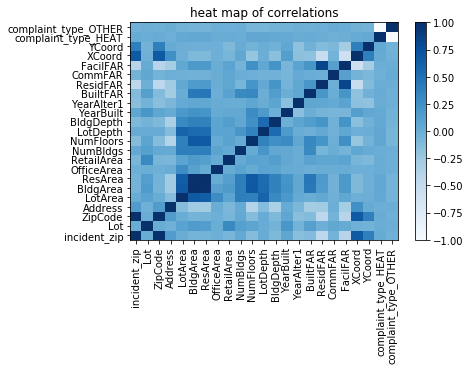

In [54]:
fig, ax = plt.subplots()
#im = ax.pcolor(AllForHeat, cmap='RdBu_r') #Reverse the red/blue colormap
im = ax.pcolor(AllForHeat, cmap='Blues')
#label names
row_labels = combined.columns
col_labels = combined.columns

#move ticks and labels to the center.
ax.set_xticks(np.arange(AllForHeat.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(AllForHeat.shape[0]) + 0.5, minor=False)

#insert labels
ax.set_xticklabels(row_labels, minor = False)
ax.set_yticklabels(col_labels, minor = False)

ax.set_title("heat map of correlations")

#rotate label if too long
plt.xticks(rotation=90)
plt.colorbar(im)
plt.show()

In [ ]:
combined.describe

In [ ]:
#Why such strong correlation between complaint type and lot?
#The PLUTO documentation shows ranges that indicate the type of lot.
#Traditional Tax Lots
#combined[combined['Lot'].between(1,999,inclusive=True)].index
combined['Lot'].value_counts()

<a id="conclusion"></a>
# Concluding Remarks
---

The HEAT/HOT WATER (including HEATING) complaint type identified in Question 1 as the most prevalent complaint type has (or does not have any????) an obvious relationship with the BRONX (identified in Question 2) house characteristics: